In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.stats import invwishart 
from scipy.stats import multivariate_normal 
from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from sklearn import metrics

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

In [3]:
from sklearn.datasets import fetch_openml 
mnist = fetch_openml('mnist_784', parser ='auto')
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

In [4]:
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

In [5]:
def e_step(X,θ,π,missing_mask,K=10,eps=1e-14):
    N,D = X.shape
    K,_ = θ.shape 
    R = np.zeros((N,K))

    for i in range(N):
        for k in range(K):
            # mask = np.where(~missing_mask[i])[0]
            mask = ~missing_mask[i]

            R[i,k] = np.log(π[k] + eps) + np.sum((X[i] * np.log(θ[k] + eps))[mask]) + np.sum(((1 - X[i]) * np.log(1 - θ[k] + eps))[mask])

    log_norm = logsumexp(R, axis=1, keepdims=True)
    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik


In [6]:
def m_step(X,R,θ,missing_mask,K=10):
    N,D = X.shape
    obs_mask = ~missing_mask

    nk = R.sum(axis=0)

    X_expected = X.copy()
    X_expected[missing_mask] = θ[obs_mask]

    new_θ = (R.T @ np.nan_to_num(X_expected))/nk[:,None]
    new_π = nk/N

    return new_π,new_θ


In [7]:
def em_algorithm(X,max_iters=100,K=10,tol=1e-4):
    N,D = X.shape

    missing_mask = np.isnan(X)

    R = rng.random((N,K))
    R /= np.sum(R,axis=1,keepdims=True)
    θ = np.random.uniform(0,1,size=(K,D))

    loglikes = []

    π,θ = m_step(X,R,missing_mask,10)

    for _ in range(0,max_iters):
        R,ll = e_step(X,θ,π,missing_mask,10)
        loglikes.append(ll)

        π,θ = m_step(X,R,missing_mask,10)

        zs = np.argmax(R, axis=1)

        if len(loglikes) > 1 and np.abs(loglikes[-1] - loglikes[-2]) < tol : break

    return zs,π,θ,loglikes


In [57]:
zs,π,θ,loglikes = em_algorithm(X_mnist_cover1)

In [58]:
metrics.adjusted_rand_score(Y_mnist_train, zs)

0.22517745473138265

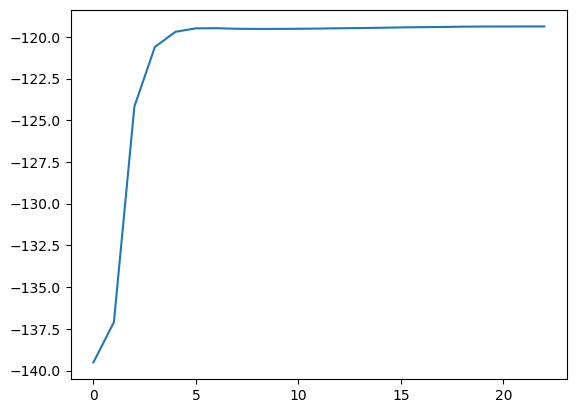

In [60]:
plt.plot(loglikes)

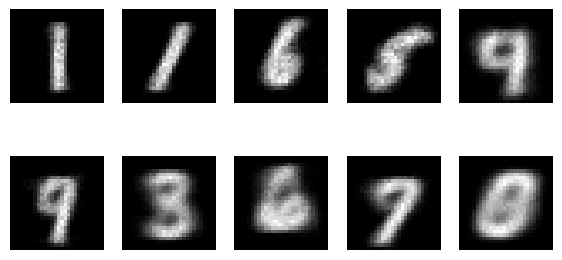

In [59]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = θ[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()